# Combining PCA and GMM For Image Creation

In [43]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(style='whitegrid')
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse

## Load image data

In [44]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=500)
print(faces.target_names)
print(faces.images.shape)

['George W Bush']
(530, 62, 47)


check the total number of samples/images, `N`

In [45]:
N=faces.images.shape[0]
N

530

check the input dimension (the number of elements in each input sample), `M`

In [46]:
#what is M?
M=faces.images.shape[1]*faces.images.shape[2]
M

2914

Next let's plot the first 100 of these to recall exactly what we're looking at:

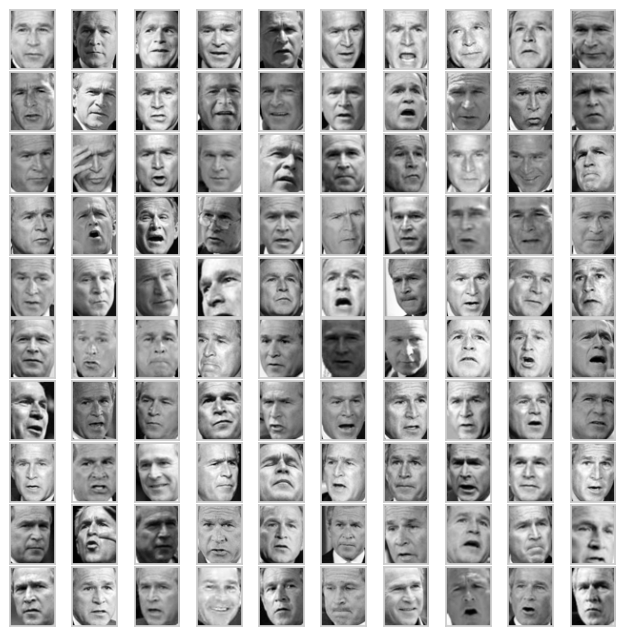

In [47]:
def plot_faces(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i], cmap='gray')
plot_faces(faces.images)

We have N images, and each image has M pixels <br>
N = 530  <  M = 2914 <br>
the number of samples is smaller than the dimension <br>
We will use dimension reduction to reduce the number of features

## Testing on smaller Dataset

### Applying PCA To The Images

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=120, whiten=True)
data = pca.fit_transform(faces.images.reshape(N,-1))

In [49]:
#check the shape of data
data.shape

(530, 120)

In [50]:
#check the value of cumulative explained variance ratio using "n_components" eigenvectors/eigenvalues
pca.explained_variance_ratio_.sum()

0.9459106

### Fitting A Gausian Mixture Model

Afer PCA transform, the number of features is changed from 2914 (62*47) to 120

N = 530,  data.shape[1] = 120

Now, we can fit many GMM to `data` with different number of components

We will select the best one based on AIC

In [51]:
#fit GMM models with different number of components
n_components = np.arange(1, 100, 10)
gmm_models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]

It looks like when n_components= ?? AIC reaches the minimum. <br>
Let's fit the GMM with n_components=?? (when AIC is minimum), and check if gmm is converged or not 

In [52]:
#find the best n_components using AIC
aic_values = []

lowest_aic = np.infty
best_gmm = None
for gmm in gmm_models:
    gmm.fit(data)
    aic = gmm.bic(data)
    aic_values.append(aic)
    if aic < lowest_aic:
        aowest_bic = aic
        best_gmm = gmm

#fit GMM using the best n_components
best_gmm.fit(data)

GaussianMixture(n_components=91, random_state=0)

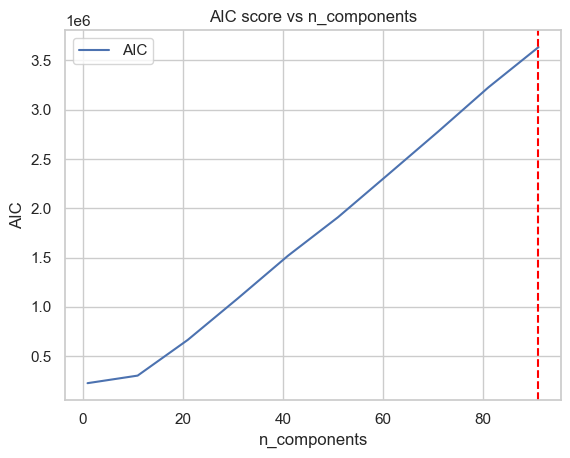

In [53]:
#plot the AIC score
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('AIC')
plt.title('AIC score vs n_components')
plt.axvline(best_gmm.n_components, color='red', linestyle='--')


The curve keeps going up: something is weird.

Let's check for convergence of the model.

note: you may get a different curve due to some randomness in initialization.

In [69]:
# Check best model for convergence
best_gmm.converged_

True

The Model does seem to have converged, but perhaps it congerged on a local minma. Further Testing is Required

In [55]:
# Draw N samples from the GMM model
data_new = best_gmm.sample(N)
data_new = data_new[0]
data_new.shape

(530, 120)

### Preforming PCA Inverse Transform

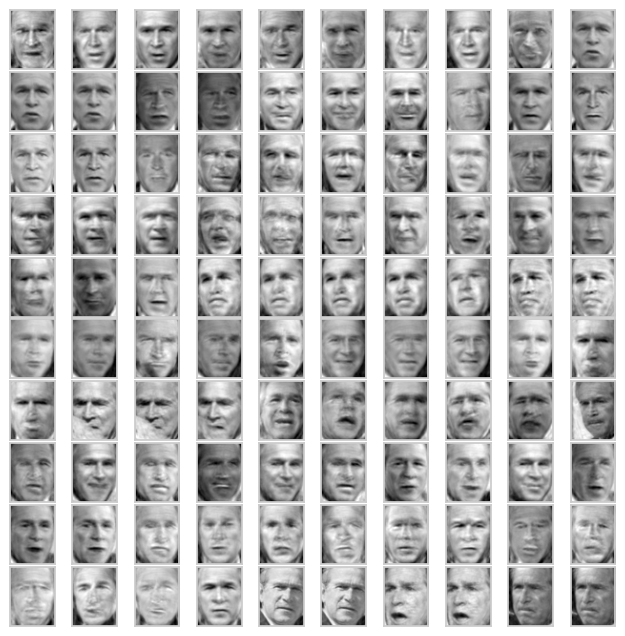

In [56]:
# Reconstruct the faces using the inverse PCA transformation
faces_new = pca.inverse_transform(data_new)
plot_faces(faces_new.reshape(-1,62, 47))

## Testing on Larger Dataset (More components in GMM)

In [57]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']
(1560, 62, 47)


In [58]:
#check the number of images
N=faces.images.shape[0]
N

1560

In [59]:
#check the input dimension (the number of elements in each input sample)
M=faces.images.shape[1]*faces.images.shape[2]
M

2914

We have N images, and each iamge has M pixels  <br>
N = 1560 and M = 2914 : N < M  <br>
We will use dimension reduction to reduce the number of features from 2914 to 120 <br>

### Applying PCA

In [ ]:
pca = PCA(n_components=120, whiten=True)
data = pca.fit_transform(faces.images.reshape(N,-1))

In [61]:
#check the shape of data
data.shape

(1560, 120)

In [62]:
#check the value of cumulative explained variance ratio
pca.explained_variance_ratio_.sum()

0.9185654

### GMM Model Optimzation

Now, fit many GMMs to the transformed `data` with different number of components

We will select the best one based on AIC

In [63]:
#fit GMM with n_components in the range of 1 to 200 with the step of 10
n_components = np.arange(1, 200, 10)
gmm_models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]

In [64]:
aic_values = []

lowest_aic = np.infty
best_gmm = None
for gmm in gmm_models:
    gmm.fit(data)
    aic = gmm.aic(data)
    aic_values.append(aic)
    if aic < lowest_aic:
        lowest_aic = aic
        best_gmm = gmm

best_gmm.n_components

51

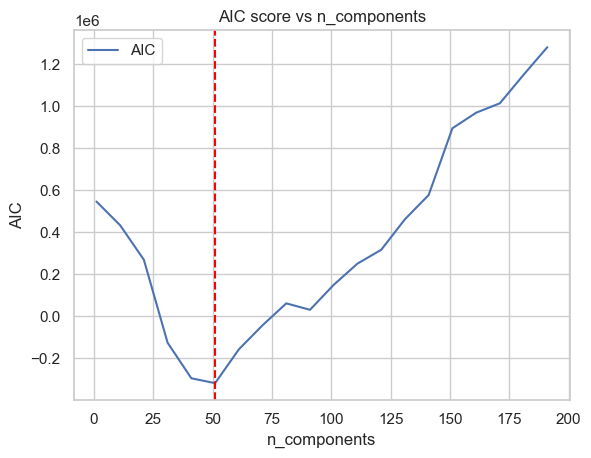

In [65]:
# Plot AIC score
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('AIC')
plt.title('AIC score vs n_components')
plt.axvline(best_gmm.n_components, color='red', linestyle='--')

Now, we have a U-haped curve, nice. (again, you may get a different curve)

It appears that AIC is miminized around 60 components.


Let's quickly fit GMM with n_components=?? (when AIC is minimum) to the `data` and confirm that it has converged:

In [66]:
# fit the GMM with n_components = the value when AIC is minimum
best_gmm.fit(data)

GaussianMixture(n_components=51, random_state=0)

## Generating Images Using Optimal GMM

In [ ]:
# Generate new samples using the GMM model
data_new = best_gmm.sample(N)
data_new = data_new[0]
data_new.shape

(1560, 120)

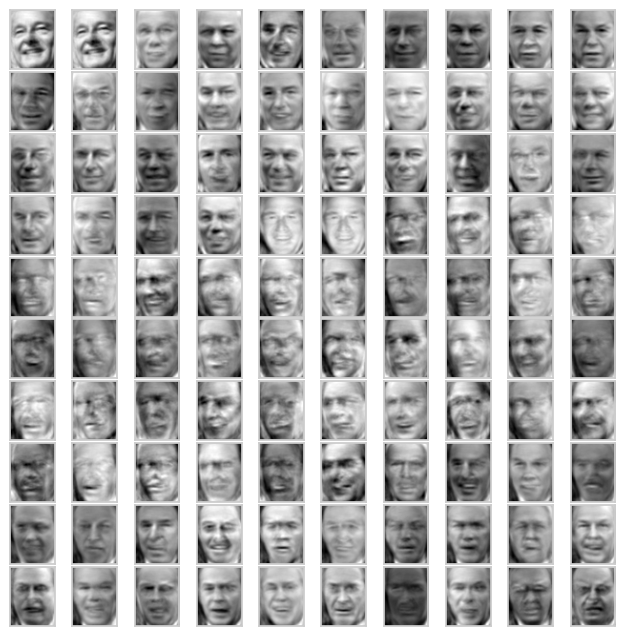

In [ ]:
faces_new = pca.inverse_transform(data_new)
plot_faces(faces_new.reshape(-1,62, 47))

GMM is good but very time consuming. PCA+GMM is a good approach to reduce time cost.